In [1]:
from pathlib import Path
import json
from collections import defaultdict
from PIL import Image
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dataset_path = Path("./dataset/voc-datasets/VOC2007")
# dataset_path = Path("./dataset/voc-datasets/VOC2012")
split = "test"

In [3]:
image_set_fp = dataset_path / "ImageSets" / "Main" / f"{split}.txt"
assert image_set_fp.exists(), f"{image_set_fp!r} not found"

with image_set_fp.open('r') as f:
    img_set_ids = [ line.strip() for line in f.readlines() ]

print(f"{len(img_set_ids)=}")

len(img_set_ids)=4952


In [4]:
ann_dir = dataset_path / "Annotations"
jpg_dir = dataset_path / "JPEGImages"

assert ann_dir.is_dir(), f"{ann_dir!r} not found"
assert jpg_dir.is_dir(), f"{jpg_dir!r} not found"

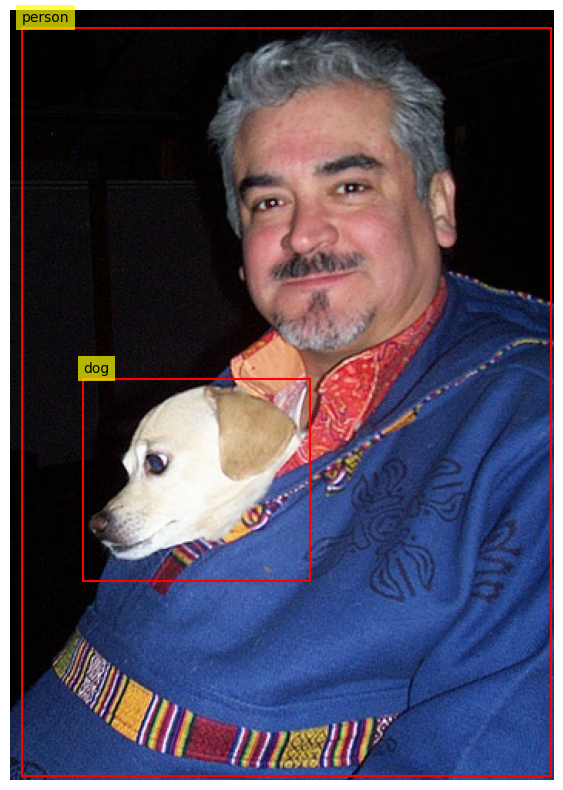

In [5]:
def parse_xml(xml_path: Path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    return root.findall('object')

img_id = img_set_ids[0]
obj_l = parse_xml(ann_dir / f"{img_id}.xml")
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
img = Image.open(jpg_dir / f"{img_id}.jpg").convert("RGB")
ax.imshow(img)
ax.axis('off')
for obj in obj_l:
      cls_name = obj.find('name').text
      bbox = obj.find('bndbox')
      x1, y1, x2, y2 = [ float(bbox.find(tag).text)-1 for tag in ["xmin", "ymin", "xmax", "ymax"] ]
      w, h = x2 - x1, y2 - y1
      ret = plt.Rectangle((x1, y1), w, h, fill=False, edgecolor='red', linewidth=1.5)
      ax.add_patch(ret)
      ax.text(x1, y1 - 4, cls_name, fontsize=10, bbox=dict(facecolor="yellow", alpha=0.7, edgecolor="none"))

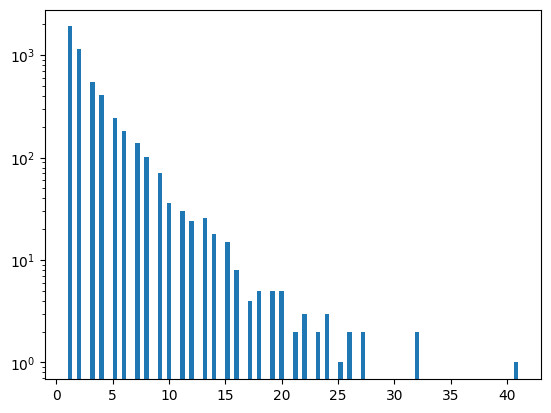

In [6]:
counts = np.array([ len(parse_xml(ann_dir / f"{img_id}.xml")) for img_id in img_set_ids ])

plt.hist(counts, bins=100)
plt.yscale('log')
plt.show()

In [7]:
max_thresh = 32 # 2**5
print("Total Images", len(counts))
print(f"Images with > {max_thresh} annotations", sum(counts > max_thresh))

Total Images 4952
Images with > 32 annotations 1


In [8]:
print(sum(counts == 0), "samples with 0 objects")

0 samples with 0 objects


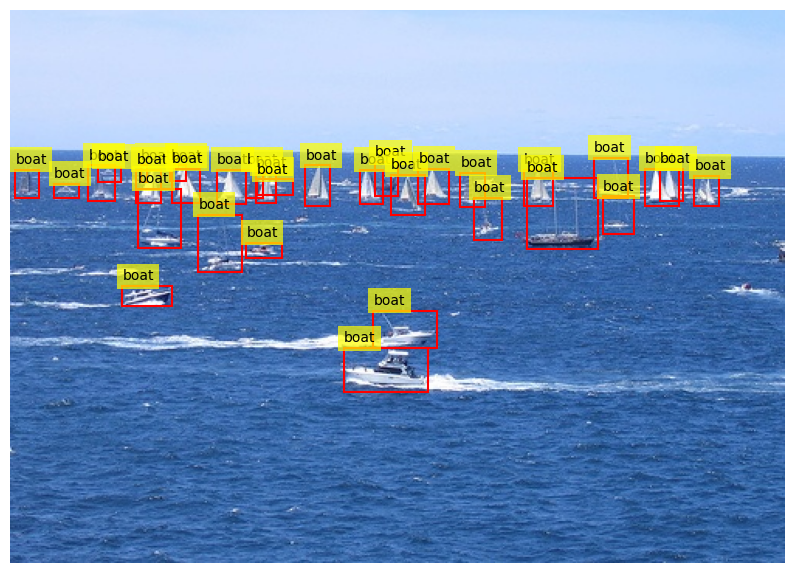

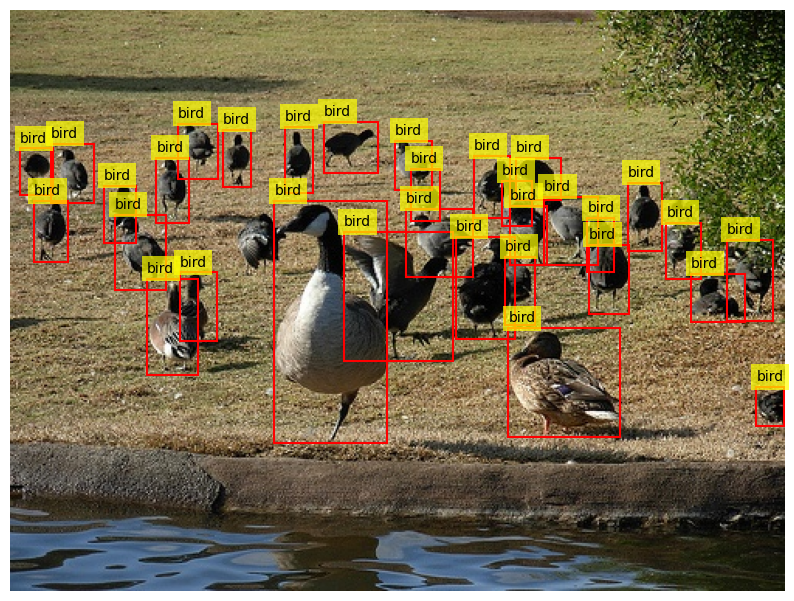

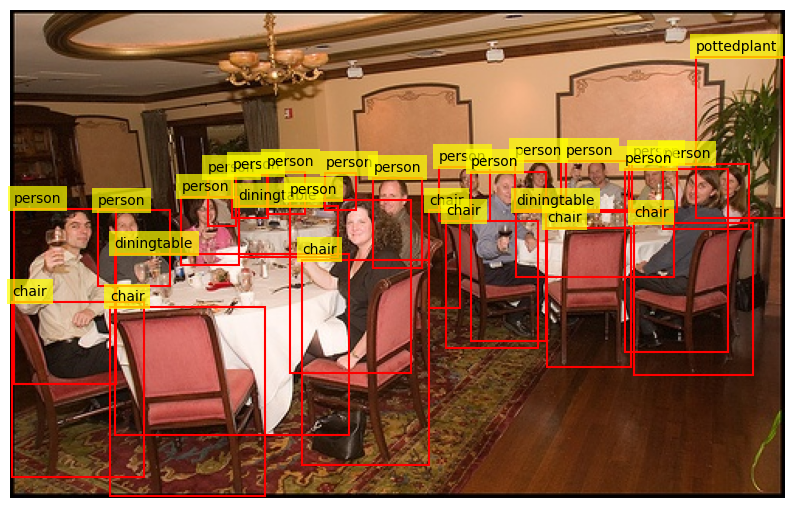

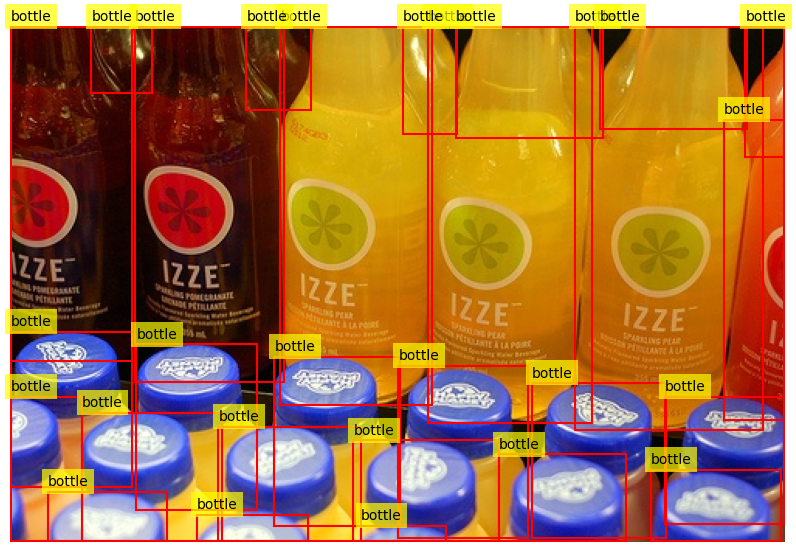

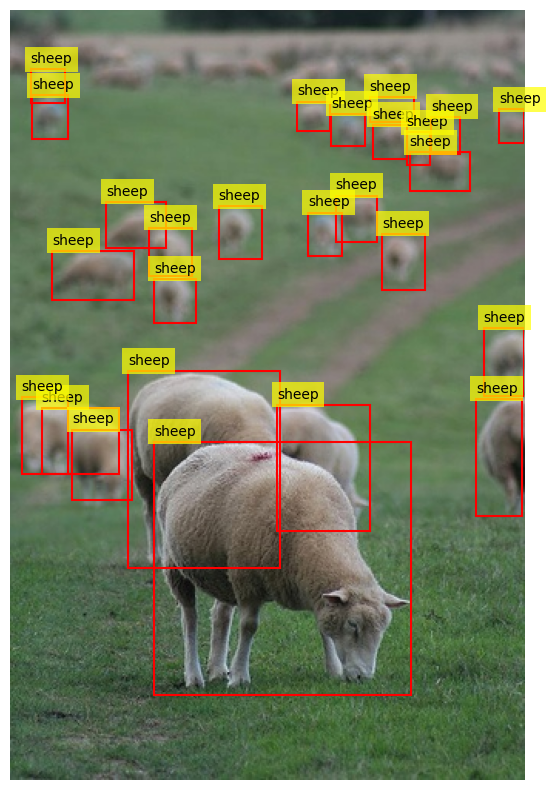

In [9]:
idx_sorted = np.argsort(counts)[::-1]

k = sum(counts > max_thresh)

for idx in idx_sorted[k:k+5]:
    img_id = img_set_ids[idx]
    obj_l = parse_xml(ann_dir / f"{img_id}.xml")
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    img = Image.open(jpg_dir / f"{img_id}.jpg").convert("RGB")
    ax.imshow(img)
    ax.axis('off')
    for obj in obj_l:
        cls_name = obj.find('name').text
        bbox = obj.find('bndbox')
        x1, y1, x2, y2 = [ float(bbox.find(tag).text)-1 for tag in ["xmin", "ymin", "xmax", "ymax"] ]
        w, h = x2 - x1, y2 - y1
        ret = plt.Rectangle((x1, y1), w, h, fill=False, edgecolor='red', linewidth=1.5)
        ax.add_patch(ret)
        ax.text(x1, y1 - 4, cls_name, fontsize=10, bbox=dict(facecolor="yellow", alpha=0.7, edgecolor="none"))

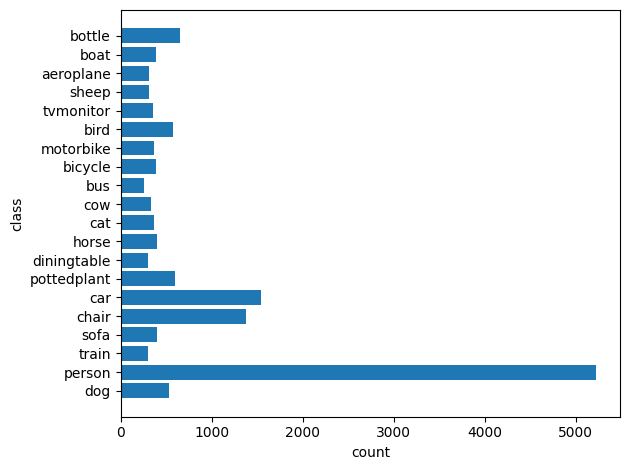

In [10]:
cat_freq = {}
for img_id in img_set_ids:
    obj_l = parse_xml(ann_dir / f"{img_id}.xml")
    for obj in obj_l:
        cls_name = obj.find('name').text
        cat_freq[cls_name] = cat_freq.get(cls_name, 0) + 1

plt.barh(cat_freq.keys(), cat_freq.values())
plt.xlabel('count')
plt.ylabel('class')
plt.tight_layout()
plt.show()

In [11]:
counts = np.array(counts)
idxs = np.where(counts == 0)[0]
print(f'sample with 0 object annotations', len(idxs))
for idx in idxs[:4]:
    img_id = img_set_ids[idx]
    obj_l = parse_xml(ann_dir / f"{img_id}.xml")
    assert len(obj_l) == 0
    img = Image.open(jpg_dir / f"{img_id}.jpg").convert("RGB")
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(img)
    ax.axis('off')
    plt.show()

sample with 0 object annotations 0


In [12]:
from tqdm.auto import tqdm
import torch
from torchvision.io import read_image

jpg_fp_l = list(Path("./dataset/voc-datasets").rglob("*.jpg"))
sum = torch.zeros(3)
total = 0
for jpg_fp in tqdm(jpg_fp_l):
    img = read_image(jpg_fp).view(3, -1)
    sum += img.sum(dim=-1)
    total += img.shape[1]
sum / total

/Users/mnjm/workspace/detr/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 27088/27088 [00:54<00:00, 495.28it/s]


tensor([114.9547, 109.3576, 101.0638])

In [5]:
from torchvision import models
from torchscan import summary

model = models.resnet101()
summary(model, input_shape=(3,1280,1280), max_depth=2)

__________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #        
resnet                       ResNet                (-1, 1000)                0              
├─conv1                      Conv2d                (-1, 64, 640, 640)        9,408          
├─bn1                        BatchNorm2d           (-1, 64, 640, 640)        257            
├─relu                       ReLU                  (-1, 64, 640, 640)        0              
├─maxpool                    MaxPool2d             (-1, 64, 320, 320)        0              
├─layer1                     Sequential            (-1, 256, 320, 320)       0              
|    └─0                     Bottleneck            (-1, 256, 320, 320)       76,292         
|    └─1                     Bottleneck            (-1, 256, 320, 320)       71,171         
|    └─2                     Bottleneck            (-1, 256, 320, 320)  

/Users/mnjm/workspace/detr/.venv/lib/python3.12/site-packages/torchscan/process/memory.py:32: UserWarning: raised: [Errno 2] No such file or directory: 'nvidia-smi'. Assuming no GPU is available.
  warnings.warn(f"raised: {e}. Assuming no GPU is available.")
